In [4]:
from tensorflow.keras.utils import normalize
from tensorflow.keras.metrics import IoU
from tensorflow.keras.metrics import MeanIoU
import tensorflow as tf
import os
import cv2
import random
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
import glob
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook
import cv2
from PIL import Image
import glob
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Reshape,Input,Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import MeanIoU
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import MeanIoU

In [5]:
image_directory = 'DataSet/images'
mask_directory = 'DataSet/masks'

In [6]:
image_names = glob.glob("DataSet/images/*.png")
mask_names = glob.glob("DataSet/masks/*.png")

image_names = image_names[:400]
mask_names = mask_names[:400]

print(image_names[0:3])
print(mask_names[0:3])

['DataSet/images\\a_0_10.png', 'DataSet/images\\a_0_11.png', 'DataSet/images\\a_0_15.png']
['DataSet/masks\\a_0_10.png', 'DataSet/masks\\a_0_11.png', 'DataSet/masks\\a_0_15.png']


In [7]:
images = [cv2.imread(img) for img in image_names]
masks = [cv2.imread(mask,0) for mask in mask_names]
for i in range(len(images)):
    images[i] = cv2.resize(images[i] , (128,128))
    images[i] = cv2.normalize(images[i], None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    masks[i] = cv2.resize(masks[i] , (128,128))
    masks[i] = cv2.normalize(masks[i], None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

In [8]:
print(len(images))
print(len(masks))

400
400


In [9]:
image_dataset = np.array(images)
mask_dataset = np.array(masks)

In [10]:
for i in range(len(images)):
    masks[i].resize(128,128,1)
    
    r_to_l_img = tf.image.flip_left_right(images[i])
    r_to_l_mask = tf.image.flip_left_right(masks[i])
    images.append(r_to_l_img)
    masks.append(r_to_l_mask)
    
    u_to_d_img = tf.image.flip_up_down(images[i])
    u_to_d_mask = tf.image.flip_up_down(masks[i])
    images.append(u_to_d_img)
    masks.append(u_to_d_mask)

In [11]:
image_dataset = np.array(images)
mask_dataset = np.array(masks)

In [12]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)

Image data shape is:  (1200, 128, 128, 3)
Mask data shape is:  (1200, 128, 128, 1)


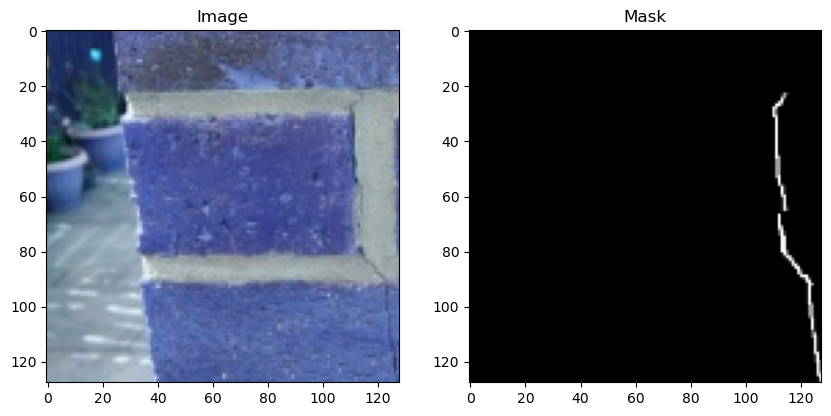

In [13]:
i = 50

# Display the image and mask side by side
plt.figure(figsize=(10, 5))

# Show the image
plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(images[i])

# Show the mask
plt.subplot(1, 2, 2)
plt.title("Mask")
plt.imshow(masks[i], cmap='gray')

plt.show()

In [14]:
X_train, X_val, Y_train, Y_val = train_test_split(image_dataset, mask_dataset, test_size=0.2, random_state=47)

In [15]:
print("Train image data shape is: ", X_train.shape)
print("Train mask data shape is: ", Y_train.shape)
print("Validation image data shape is: ", X_val.shape)
print("Validation mask data shape is: ", Y_val.shape)

Train image data shape is:  (960, 128, 128, 3)
Train mask data shape is:  (960, 128, 128, 1)
Validation image data shape is:  (240, 128, 128, 3)
Validation mask data shape is:  (240, 128, 128, 1)


In [16]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
input_shape

(128, 128, 3)

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook
import cv2
from PIL import Image
import glob
import random

def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins=true_objects)[0]
    area_pred = np.histogram(y_pred, bins=pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:, 1:]
    union = union[1:, 1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

In [18]:
def iou_metric_batch(true_masks, pred_masks):
    intersection = np.sum((true_masks == 1) & (pred_masks == 1), axis=(1, 2))
    union = np.sum((true_masks == 1) | (pred_masks == 1), axis=(1, 2))
    iou = np.mean(intersection / (union + 1e-6))  # Küçük bir epsilon ekleyin
    return iou


<h1>Model</h1>
<p>U-Net, U-Net++, SegNet, and UsquareNet are models that can be run.</p>
<p>DeepLabv3 is not run.</p>

In [19]:

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [20]:
import tensorflow as tf
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D, Dropout, BatchNormalization, Activation
from keras.models import Model

def get_U2net(inputs):
    def conv2d_bn_act(x, size, filters=(3,3), padding='same', dilation_rate=(1,1), activation='relu', kernel_initializer='he_normal'):
        x = Conv2D(size, filters, padding=padding, dilation_rate=dilation_rate, kernel_initializer=kernel_initializer)(x)
        x = BatchNormalization()(x)
        x = Activation(activation)(x)
        return x

    def get_en1(hx):
        c1i = conv2d_bn_act(hx, 16)
        c1 = conv2d_bn_act(c1i, 16)
        p1 = MaxPooling2D((2, 2))(c1)
        c2 = conv2d_bn_act(p1, 32)
        p2 = MaxPooling2D((2, 2))(c2)
        c3 = conv2d_bn_act(p2, 64)
        p3 = MaxPooling2D((2, 2))(c3)
        c4 = conv2d_bn_act(p3, 128)
        c4 = tf.keras.layers.Dropout(0.2)(c4)
        p4 = MaxPooling2D((2, 2))(c4)

        c5 = conv2d_bn_act(p4, 256)
        c6 = conv2d_bn_act(c5, 256, dilation_rate=(2,2))
        c7 = conv2d_bn_act(c6, 256)
        c7 = tf.keras.layers.Dropout(0.2)(c7)

        u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
        u8 = concatenate([u8, c4])
        c8 = conv2d_bn_act(u8, 128)
        u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
        u9 = concatenate([u9, c3])
        c9 = conv2d_bn_act(u9, 64)
        u10 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
        u10 = concatenate([u10, c2])
        c10 = conv2d_bn_act(u10, 32)
        u11 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c10)
        u11 = concatenate([u11, c1])
        c11 = conv2d_bn_act(u11, 16)

        return c11 + c1i

    def get_en2(hx):
        c2i = conv2d_bn_act(hx, 32)
        c2 = conv2d_bn_act(c2i, 32)
        p2 = MaxPooling2D((2, 2))(c2)
        c3 = conv2d_bn_act(p2, 64)
        p3 = MaxPooling2D((2, 2))(c3)
        c4 = conv2d_bn_act(p3, 128)
        c4 = tf.keras.layers.Dropout(0.2)(c4)
        p4 = MaxPooling2D((2, 2))(c4)

        c5 = conv2d_bn_act(p4, 256)
        c6 = conv2d_bn_act(c5, 256, dilation_rate=(2, 2))
        c7 = conv2d_bn_act(c6, 256)
        c7 = tf.keras.layers.Dropout(0.2)(c7)

        u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
        u8 = concatenate([u8, c4])
        c8 = conv2d_bn_act(u8, 128)
        u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
        u9 = concatenate([u9, c3])
        c9 = conv2d_bn_act(u9, 64)
        u10 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
        u10 = concatenate([u10, c2])
        c10 = conv2d_bn_act(u10, 32)

        return c10 + c2i

    def get_en3(hx):
        c3i = conv2d_bn_act(hx, 64)
        c3 = conv2d_bn_act(c3i, 64)
        p3 = MaxPooling2D((2, 2))(c3)
        c4 = conv2d_bn_act(p3, 128)
        c4 = tf.keras.layers.Dropout(0.2)(c4)
        p4 = MaxPooling2D((2, 2))(c4)

        c5 = conv2d_bn_act(p4, 256)
        c6 = conv2d_bn_act(c5, 256, dilation_rate=(2, 2))
        c7 = conv2d_bn_act(c6, 256)
        c7 = tf.keras.layers.Dropout(0.2)(c7)

        u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
        u8 = concatenate([u8, c4])
        c8 = conv2d_bn_act(u8, 128)
        u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
        u9 = concatenate([u9, c3])
        c9 = conv2d_bn_act(u9, 64)

        return c9 + c3i

    def get_en4(hx):
        c4i = conv2d_bn_act(hx, 128)
        c4 = conv2d_bn_act(c4i, 256)
        c4 = tf.keras.layers.Dropout(0.2)(c4)
        p4 = MaxPooling2D((2, 2))(c4)

        c5 = conv2d_bn_act(p4, 256)
        c6 = conv2d_bn_act(c5, 256, dilation_rate=(2, 2))
        c7 = conv2d_bn_act(c6, 256)
        c7 = tf.keras.layers.Dropout(0.2)(c7)

        u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
        u8 = concatenate([u8, c4])
        c8 = conv2d_bn_act(u8, 128)

        return c8 + c4i

    def get_en5(hx):
        c5i = conv2d_bn_act(hx, 256)
        c5 = conv2d_bn_act(c5i, 256)
        c6 = conv2d_bn_act(c5, 256, dilation_rate=(2, 2))
        c7 = conv2d_bn_act(c6, 256, dilation_rate=(4, 4))
        c7 = tf.keras.layers.Dropout(0.2)(c7)

        c8 = conv2d_bn_act(c7, 256, dilation_rate=(8, 8))
        c9 = conv2d_bn_act(c8, 256, dilation_rate=(4, 4))
        c9 = tf.keras.layers.Dropout(0.2)(c9)
        c9 = concatenate([c9, c7])
        c10 = conv2d_bn_act(c9, 256, dilation_rate=(2, 2))
        c10 = concatenate([c10, c6])
        c11 = conv2d_bn_act(c10, 256)

        return c11 + c5i

    hx1 = get_en1(inputs)
    hx = MaxPooling2D(pool_size=(2, 2))(hx1)
    hx2 = get_en2(hx)
    hx = MaxPooling2D(pool_size=(2, 2))(hx2)
    hx3 = get_en3(hx)
    hx = MaxPooling2D(pool_size=(2, 2))(hx3)
    hx4 = get_en4(hx)
    hx = MaxPooling2D(pool_size=(2, 2))(hx4)
    hx5 = get_en5(hx)
    hx5dup = UpSampling2D(size=(2, 2), interpolation='bilinear')(hx5)

    con4 = concatenate([hx5dup,hx4])
    hx4d = get_en4(con4)
    hx4dup = UpSampling2D(size=(2, 2), interpolation='bilinear')(hx4d)
    con3 = concatenate([hx4dup,hx3])
    hx3d = get_en3(con3)
    hx3dup = UpSampling2D(size=(2, 2), interpolation='bilinear')(hx3d)
    con2 = concatenate([hx3dup,hx2])
    hx2d = get_en2(con2)
    hx2dup = UpSampling2D(size=(2, 2), interpolation='bilinear')(hx2d)
    con1 = concatenate([hx2dup,hx1])
    hx1d = get_en1(con1)

    d1 = Conv2D(16, (3, 3), activation='sigmoid', padding='same')(hx1d)
    d2 = Conv2D(32, (3, 3), activation='sigmoid', padding='same')(hx2d)
    d2 = UpSampling2D(size=(2, 2), interpolation='bilinear')(d2)
    d3 = Conv2D(64, (3, 3), activation='sigmoid', padding='same')(hx3d)
    d3 = UpSampling2D(size=(4, 4), interpolation='bilinear')(d3)
    d4 = Conv2D(128, (3, 3), activation='sigmoid', padding='same')(hx4d)
    d4 = UpSampling2D(size=(8, 8), interpolation='bilinear')(d4)
    d5 = Conv2D(256, (3, 3), activation='sigmoid', padding='same')(hx5)
    d5 = UpSampling2D(size=(16, 16), interpolation='bilinear')(d5)

    con_last = concatenate([d1,d2,d3,d4,d5])
    d0 = Conv2D(1, (1, 1), activation='sigmoid')(con_last)

    model = Model(inputs=[inputs], outputs=[d0], name="Usquare-Net")
    return model

In [21]:
import tensorflow as tf
from tensorflow import keras

def segnet(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Encoder
    conv1 = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(pool1)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(pool2)
    pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(pool3)
    pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    # Decoder
    up5 = keras.layers.UpSampling2D(size=(2, 2))(pool4)
    deconv5 = keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(up5)

    up6 = keras.layers.UpSampling2D(size=(2, 2))(deconv5)
    deconv6 = keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(up6)

    up7 = keras.layers.UpSampling2D(size=(2, 2))(deconv6)
    deconv7 = keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(up7)

    up8 = keras.layers.UpSampling2D(size=(2, 2))(deconv7)
    deconv8 = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(up8)

    # Output layer with sigmoid activation for binary classification
    outputs = keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(deconv8)


    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


In [22]:
def aspp_module(inputs, dilation_rates):
    # ASPP branch 1: Dilated Convolution
    branch1 = Conv2D(256, (1, 1), padding='same', use_bias=False)(inputs)
    branch1 = BatchNormalization()(branch1)
    branch1 = Activation('relu')(branch1)

    # ASPP branch 2: Dilated Convolution with different dilation rates
    branch2 = Conv2D(256, (3, 3), padding='same', dilation_rate=dilation_rates[0], use_bias=False)(inputs)
    branch2 = BatchNormalization()(branch2)
    branch2 = Activation('relu')(branch2)

    branch3 = Conv2D(256, (3, 3), padding='same', dilation_rate=dilation_rates[1], use_bias=False)(inputs)
    branch3 = BatchNormalization()(branch3)
    branch3 = Activation('relu')(branch3)

    branch4 = Conv2D(256, (3, 3), padding='same', dilation_rate=dilation_rates[2], use_bias=False)(inputs)
    branch4 = BatchNormalization()(branch4)
    branch4 = Activation('relu')(branch4)

    # Global Average Pooling branch
    b5 = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    b5 = tf.keras.layers.Reshape((1, 1, inputs.shape[-1]))(b5)
    b5 = Conv2D(256, (1, 1), padding='same', use_bias=False)(b5)
    b5 = BatchNormalization()(b5)
    b5 = Activation('relu')(b5)
    b5 = UpSampling2D(size=(4, 4), interpolation='bilinear')(b5)

    # Concatenate ASPP branches
    x = tf.keras.layers.Concatenate()([branch1, branch2, branch3, branch4, b5])
    return x

def DeepLabv3Plus(input_shape, output_shape):
    # Backbone: MobileNetV2 
    backbone = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False)

    # ASPP 
    x = backbone.output
    x = aspp_module(x, [6, 12, 18])  # Dilatasyon oranları

    # Decoder 
    x = UpSampling2D(size=(4, 4), interpolation='bilinear')(x)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)  

    model = Model(inputs=backbone.input, outputs=outputs, name='DeepLabv3Plus')

    return model

In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, LeakyReLU, MaxPooling2D, UpSampling2D, Concatenate

# Define ConvBlock with Dropout, BatchNormalization, and LeakyReLU
def ConvBlock(x, filters, kernel_size=(3, 3), strides=(1, 1), padding='same', dropout_rate=0.5):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = LeakyReLU(alpha=0.01)(x)  # Updated argument
    return x

# Define Upsampling block
def UpBlock(x, skip_input):
    x = UpSampling2D(size=(2, 2))(x)
    x = Concatenate()([x, skip_input])
    return x

# Define UNet++ model
def UNetPlusPlus(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Encoder path
    conv1 = ConvBlock(inputs, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = ConvBlock(pool1, 64)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = ConvBlock(pool2, 128)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = ConvBlock(pool3, 256)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottom layer (Bottleneck)
    conv5 = ConvBlock(pool4, 512)

    # Decoder path with attention gates
    up6 = UpBlock(conv5, conv4)
    conv6 = ConvBlock(up6, 256)

    up7 = UpBlock(conv6, conv3)
    conv7 = ConvBlock(up7, 128)

    up8 = UpBlock(conv7, conv2)
    conv8 = ConvBlock(up8, 64)

    up9 = UpBlock(conv8, conv1)
    conv9 = ConvBlock(up9, 32)

    # Output layer
    if num_classes == 1:  # Binary classification
        activation = 'sigmoid'
    else:  # Multi-class classification
        activation = 'softmax'

    outputs = Conv2D(num_classes, (1, 1), activation=activation, padding='same')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='unet_plus_plus')
    print(f"unet_plus_plus Output activation function: {activation}")
    
    return model

<h1>Model fit</h1>

In [24]:
random_indices = random.sample(range(X_val.shape[0]), 5)  # 5 random image 
test_images = X_val[random_indices]
test_masks = Y_val[random_indices]

In [25]:
n_classes = 1
inputs = tf.keras.Input(input_shape)
print(input_shape)

(128, 128, 3)


In [26]:
model_UNetPlusPlus = UNetPlusPlus(input_shape, n_classes)
#model_DeepLab = DeepLabv3Plus(input_shape, (128, 128, 1))
model_SegNet = segnet(input_shape, n_classes)
model_U2net = get_U2net(inputs)
model_Unet = build_unet(input_shape,n_classes)

C:\Users\ilker\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


unet_plus_plus Output activation function: sigmoid
sigmoid


In [27]:
# Modelleri eğitme ve değerlendirme
models = [model_UNetPlusPlus,model_SegNet,model_U2net,model_Unet]  # Tanımlanan modellerin listesi
model_names = ['model_UNetPlusPlus','model_SegNet','model_U2net','model_Unet']


model_save_path = 'saved_models'
os.makedirs(model_save_path, exist_ok=True)

performances = []
histories = []
predictions = []

In [28]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
for model, name in zip(models, model_names):

    print(f"Eğitiliyor: {name}")
    
    model.compile(optimizer=Adam(learning_rate = 1e-3),
                  loss='binary_crossentropy', 
                  metrics=['accuracy', MeanIoU(num_classes=2)])
    
    history  = model.fit(X_train, Y_train,
                  validation_data=(X_val, Y_val),
                  batch_size=16,
                  verbose=1,
                  epochs=10,
                  shuffle=False) 
    
    
    histories.append(history) 
    
    predict_model = model.predict(test_images)
    predictions.append(predict_model)
    
    model_path = os.path.join(model_save_path, f"{name}.keras")
    model.save(model_path)
    print(f"Model {name} kaydedildi: {model_path}")

Eğitiliyor: model_UNetPlusPlus
Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.8208 - loss: 0.4136 - mean_io_u: 0.4979 - val_accuracy: 0.5839 - val_loss: 0.7216 - val_mean_io_u: 0.4916
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9532 - loss: 0.1535 - mean_io_u: 0.5182 - val_accuracy: 0.2183 - val_loss: 1.1854 - val_mean_io_u: 0.4916
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9554 - loss: 0.1175 - mean_io_u: 0.5176 - val_accuracy: 0.9526 - val_loss: 0.1270 - val_mean_io_u: 0.4916
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9558 - loss: 0.1004 - mean_io_u: 0.5146 - val_accuracy: 0.9526 - val_loss: 0.1351 - val_mean_io_u: 0.4916
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.9565 - loss: 0.0901 - mean_io_u: 0.5134 - val_accuracy: 0.9526 - val_loss: 0.1435 - val_mean_io_u: 0.4916
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9570 - loss: 0.0831 - mean_io_u: 0.5136 - val_accuracy:

<h1>Model evaluate and plot</h1>

Plotting loss for model_UNetPlusPlus
History keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'val_accuracy', 'val_loss', 'val_mean_io_u'])
model_UNetPlusPlus - First few training losses: [0.2897490859031677, 0.1442226618528366, 0.11343197524547577, 0.09781241416931152, 0.08811918646097183]
model_UNetPlusPlus - First few validation losses: [0.7215913534164429, 1.1853891611099243, 0.12697641551494598, 0.13511821627616882, 0.14351220428943634]
model_UNetPlusPlus - Number of epochs: 10


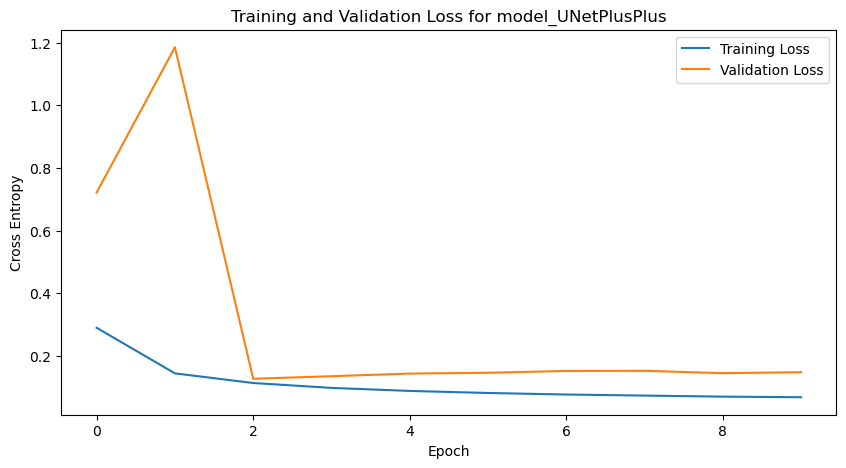

Plotting loss for model_SegNet
History keys: dict_keys(['accuracy', 'loss', 'mean_io_u_1', 'val_accuracy', 'val_loss', 'val_mean_io_u_1'])
model_SegNet - First few training losses: [0.1575051099061966, 0.10026289522647858, 0.08824130147695541, 0.07859418541193008, 0.07345066219568253]
model_SegNet - First few validation losses: [0.11019045859575272, 0.09581290185451508, 0.08289182931184769, 0.07980607450008392, 0.07517518848180771]
model_SegNet - Number of epochs: 10


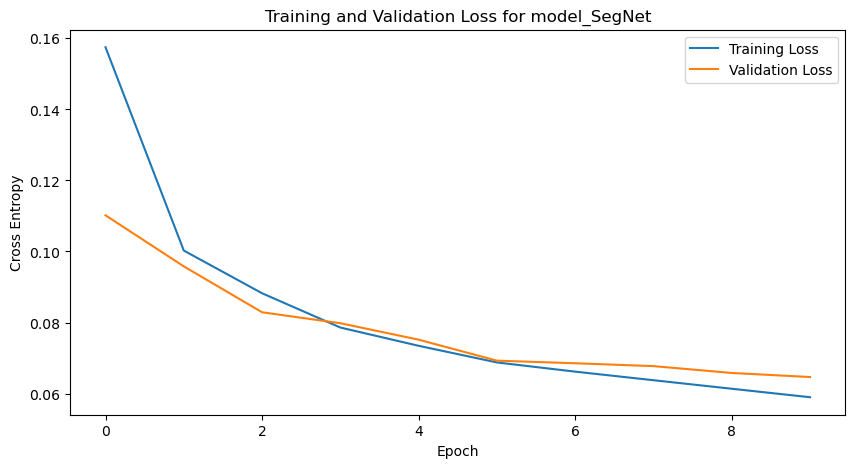

Plotting loss for model_U2net
History keys: dict_keys(['accuracy', 'loss', 'mean_io_u_2', 'val_accuracy', 'val_loss', 'val_mean_io_u_2'])
model_U2net - First few training losses: [0.1321510672569275, 0.07489684969186783, 0.06450532376766205, 0.058038391172885895, 0.05496576055884361]
model_U2net - First few validation losses: [0.16284118592739105, 0.12468481063842773, 0.07313646376132965, 0.08761200308799744, 0.06274911016225815]
model_U2net - Number of epochs: 10


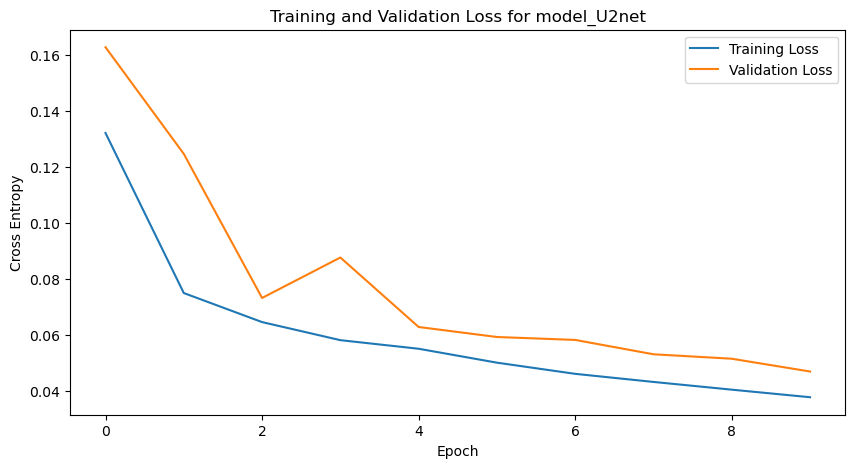

Plotting loss for model_Unet
History keys: dict_keys(['accuracy', 'loss', 'mean_io_u_3', 'val_accuracy', 'val_loss', 'val_mean_io_u_3'])
model_Unet - First few training losses: [0.24462877213954926, 0.10314350575208664, 0.08330371975898743, 0.07444026321172714, 0.07087992131710052]
model_Unet - First few validation losses: [0.26440393924713135, 0.15580567717552185, 0.12858103215694427, 0.128296360373497, 0.12637782096862793]
model_Unet - Number of epochs: 10


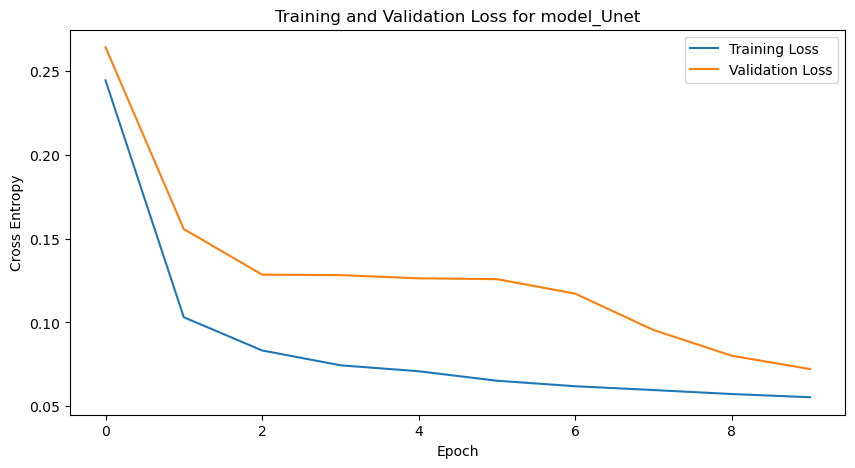

In [29]:
# Function to plot the loss
def plot_loss(history, model_name):
    if 'loss' in history.history and 'val_loss' in history.history:
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        
        print(f"{model_name} - Number of epochs: {len(loss)}")
        
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(loss)), loss, label='Training Loss')
        plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.ylabel('Cross Entropy')
        plt.title(f'Training and Validation Loss for {model_name}')
        plt.xlabel('Epoch')
        plt.show()
    else:
        print(f"Loss or validation loss not found in history for {model_name}.")

# Plotting loss for each model
for history, name in zip(histories, model_names):
    print(f"Plotting loss for {name}")
    print(f"History keys: {history.history.keys()}")
    print(f"{name} - First few training losses: {history.history['loss'][:5]}")
    print(f"{name} - First few validation losses: {history.history['val_loss'][:5]}")
    plot_loss(history, name)

  0%|          | 0/31 [00:00<?, ?it/s]

model_UNetPlusPlus -> En İyi Eşik: 0.2, En İyi IoU: 0.011249999888671878


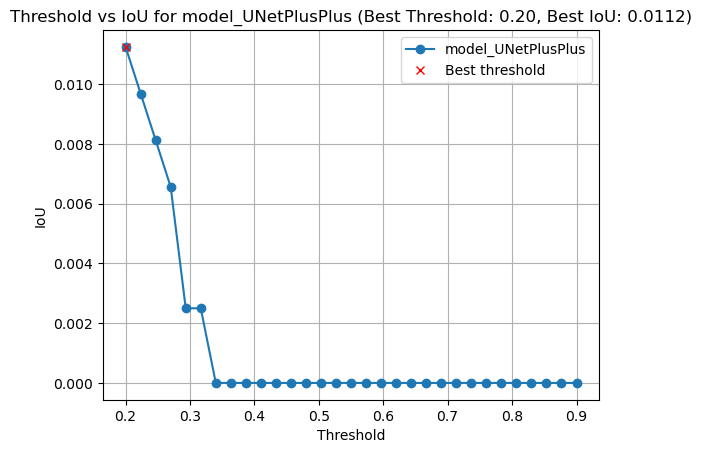

  0%|          | 0/31 [00:00<?, ?it/s]

model_SegNet -> En İyi Eşik: 0.38666666666666666, En İyi IoU: 0.0835788783578796


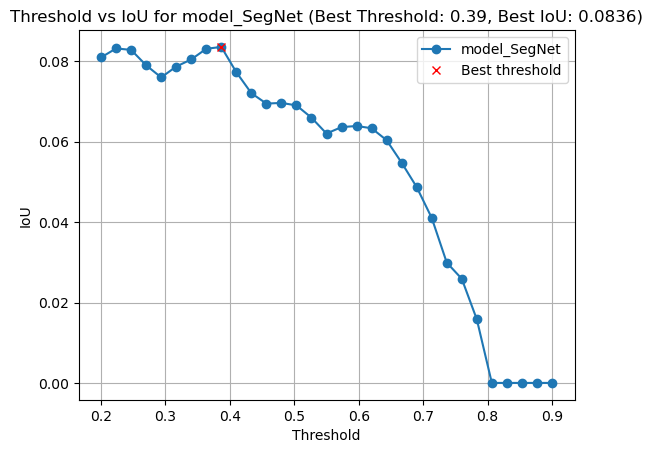

  0%|          | 0/31 [00:00<?, ?it/s]

model_U2net -> En İyi Eşik: 0.22333333333333333, En İyi IoU: 0.08898326802715413


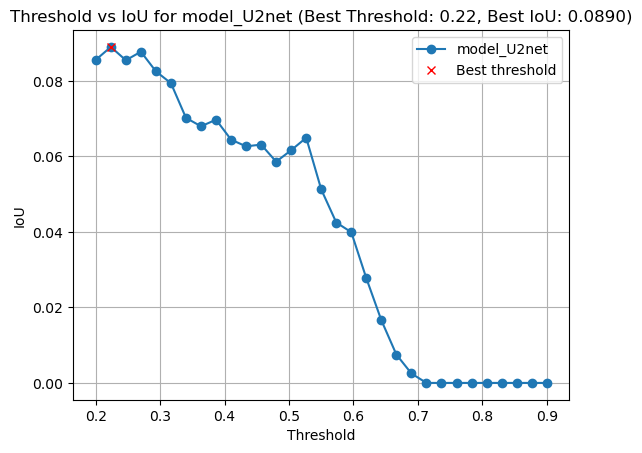

  0%|          | 0/31 [00:00<?, ?it/s]

model_Unet -> En İyi Eşik: 0.36333333333333334, En İyi IoU: 0.08214899965450252


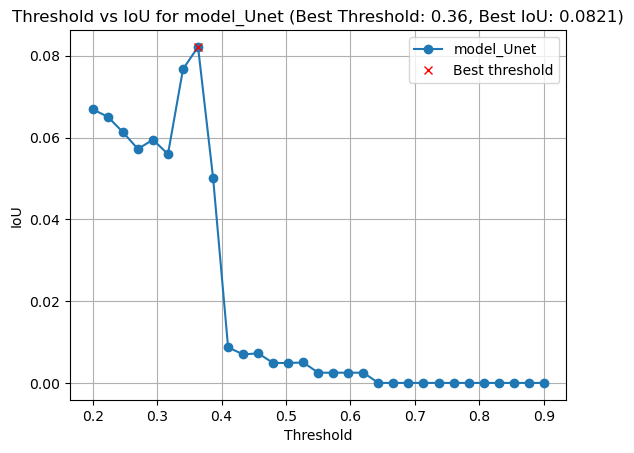

In [30]:
from tqdm.notebook import tqdm

def evaluate_and_plot_iou(model_name, predict_model, test_masks):
    thresholds = np.linspace(0.2, 0.9, 31)
    ious = np.array([iou_metric_batch(test_masks, np.int32(predict_model > threshold)) for threshold in tqdm_notebook(thresholds)])
    threshold_best_index = np.argmax(ious)
    iou_best = ious[threshold_best_index]
    threshold_best = thresholds[threshold_best_index]

    #According to Best Iuo score
   
    print(f"{model_name} -> En İyi Eşik: {threshold_best}, En İyi IoU: {iou_best}")

    plt.plot(thresholds, ious, marker='o', label=model_name)
    plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
    plt.xlabel("Threshold")
    plt.ylabel("IoU")
    plt.title(f"Threshold vs IoU for {model_name} (Best Threshold: {threshold_best:.2f}, Best IoU: {iou_best:.4f})")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return model_name, threshold_best, iou_best

def evaluate_all_models(model_names, predictions, test_masks):
    results = []
    for name, prediction in zip(model_names, predictions):
        performance = evaluate_and_plot_iou(name, prediction, test_masks)
        results.append(performance)
    return results

results = evaluate_all_models(model_names, predictions, test_masks)


UNet++ :0.014892578125, SegNet :0.014892578125, U2net  :0.014892578125, Unet   :0.014892578125


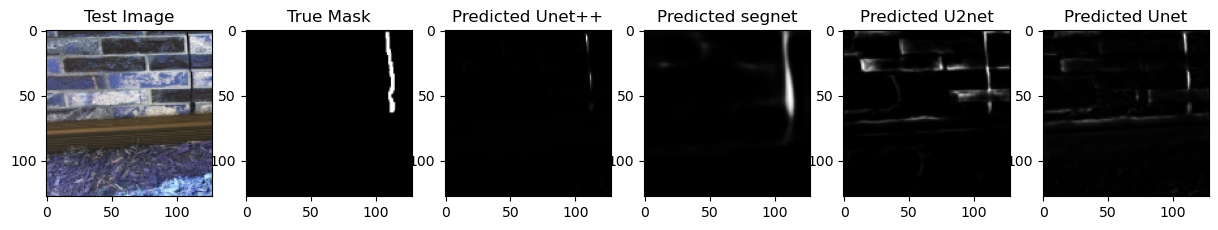

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


UNet++ :0.04644775390625, SegNet :0.04644775390625, U2net  :0.04644775390625, Unet   :0.04644775390625


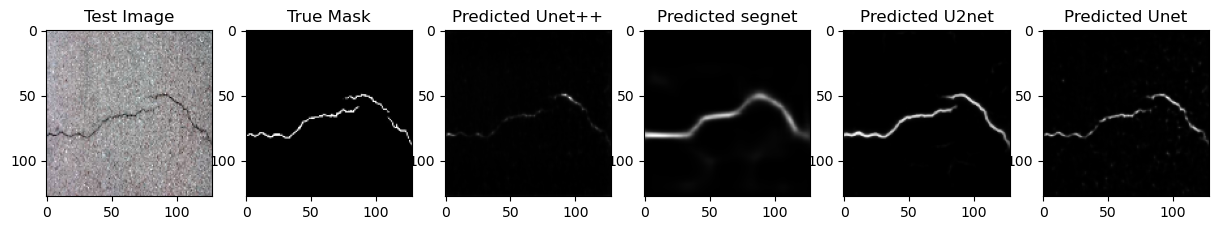

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


UNet++ :0.0408935546875, SegNet :0.0408935546875, U2net  :0.0408935546875, Unet   :0.0408935546875


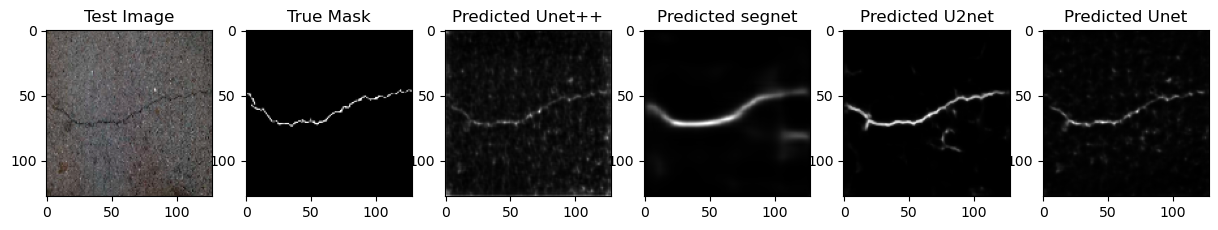

UNet++ :0.0428466796875, SegNet :0.0428466796875, U2net  :0.0428466796875, Unet   :0.0428466796875


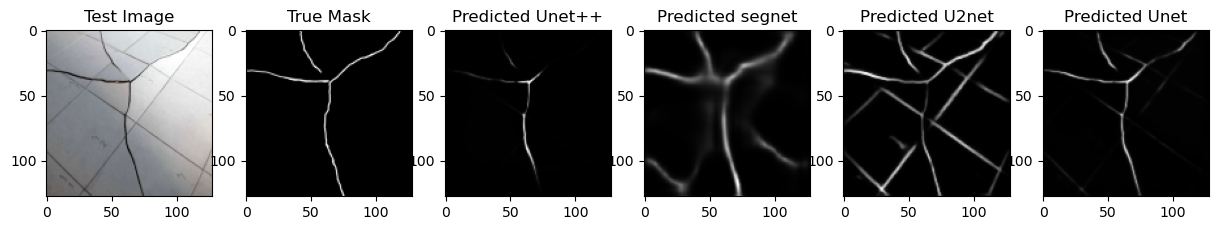

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


UNet++ :0.0096435546875, SegNet :0.0096435546875, U2net  :0.0096435546875, Unet   :0.0096435546875


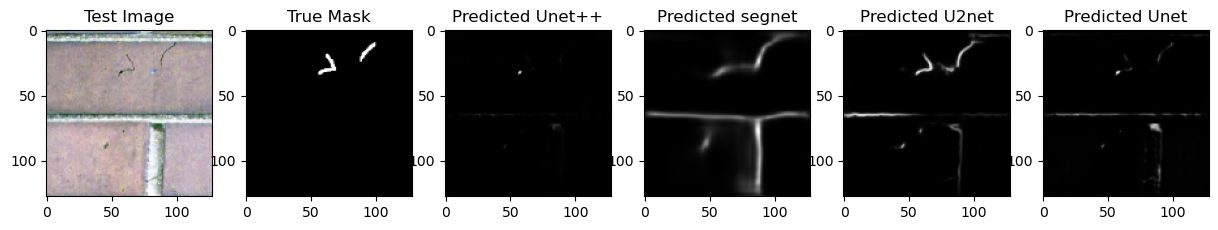

In [31]:
def calculate_iou(true_mask, pred_mask):
    intersection = np.logical_and(true_mask, pred_mask).sum()
    union = np.logical_or(true_mask, pred_mask).sum()
    iou = intersection / union
    return iou


# Best threshold
for i in range(len(test_images)):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 6, 1)
    plt.title("Test Image")
    plt.imshow(test_images[i])
    
    plt.subplot(1, 6, 2)
    plt.title("True Mask")
    plt.imshow(test_masks[i], cmap="gray")

    iou_unetpp = calculate_iou(test_masks[i], predictions[0][i])
    iou_segnet = calculate_iou(test_masks[i], predictions[1][i])
    iou_u2net = calculate_iou(test_masks[i], predictions[2][i])
    iou_unet = calculate_iou(test_masks[i], predictions[3][i])

    print(f"UNet++ :{iou_unetpp}, SegNet :{iou_segnet}, U2net  :{iou_u2net}, Unet   :{iou_unet}")

    
    plt.subplot(1, 6, 3)
    plt.title("Predicted Unet++")
    plt.imshow(predictions[0][i], cmap="gray")
    
    plt.subplot(1, 6, 4)
    plt.title("Predicted segnet")
    plt.imshow(predictions[1][i], cmap="gray")

    plt.subplot(1, 6, 5)
    plt.title("Predicted U2net")
    plt.imshow(predictions[2][i], cmap="gray")
    
    plt.subplot(1, 6, 6)
    plt.title("Predicted Unet")
    plt.imshow(predictions[3][i], cmap="gray")
    
    plt.show()

Prediction 0 - Min: 0.0001274689711863175, Max: 0.4690414071083069
Prediction 1 - Min: 1.1986649042228237e-05, Max: 0.8182530999183655
Prediction 2 - Min: 1.5410205378429964e-05, Max: 0.8093258738517761
Prediction 3 - Min: 0.0008749886183068156, Max: 0.7146989703178406


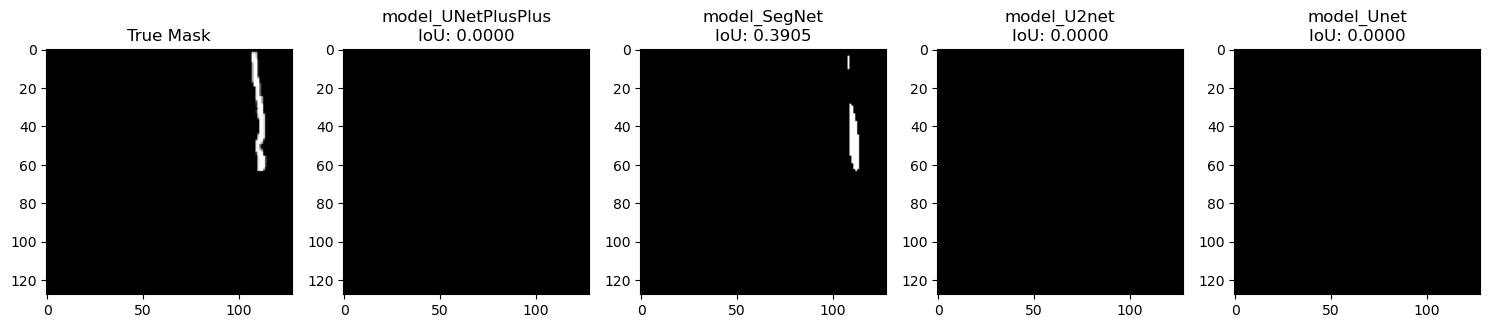

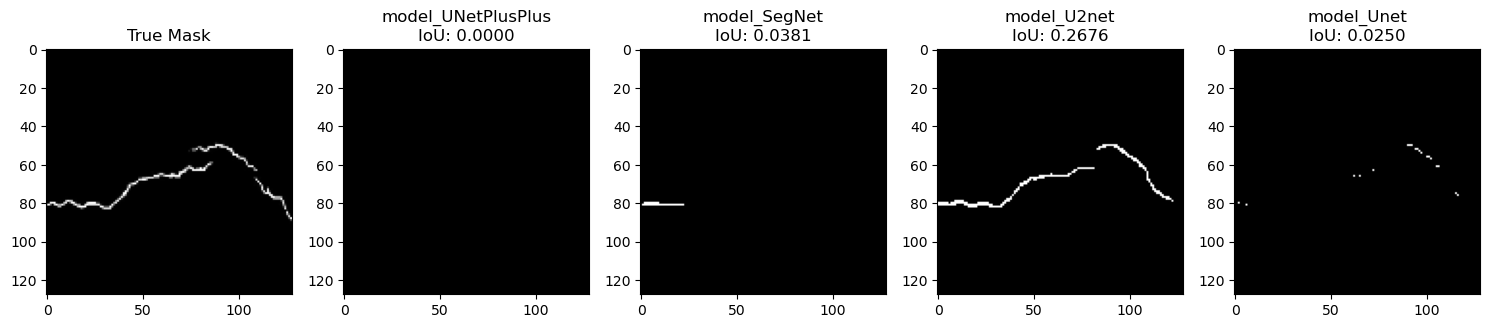

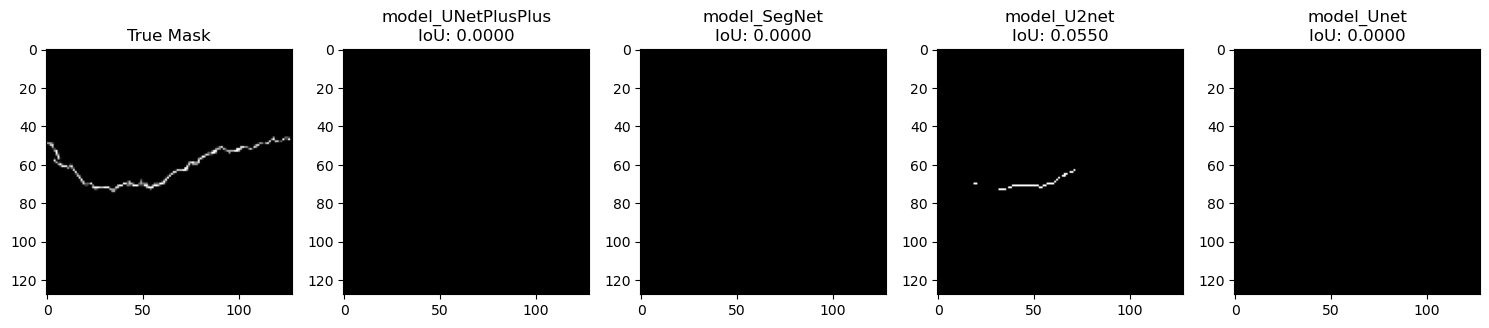

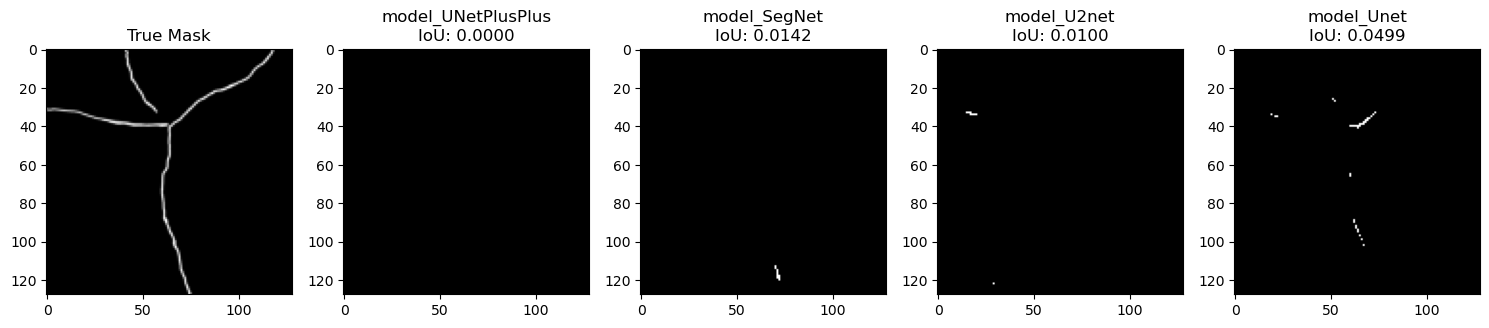

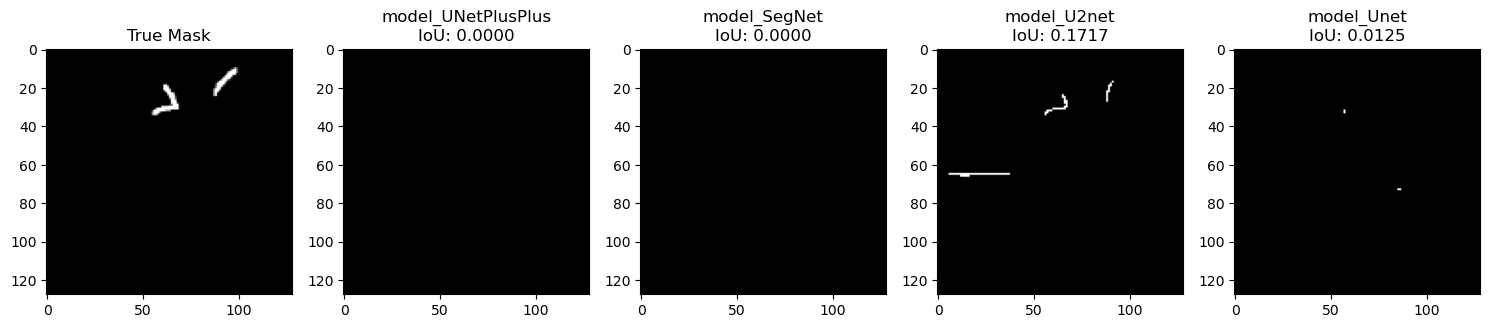

model_Unet - Threshold: 0.5
Binary Prediction Shape: (128, 128, 1)
Unique Values in Binary Prediction: [0 1]


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import IoU


# Additional checks for predictions
for i, prediction in enumerate(predictions):
    print(f"Prediction {i} - Min: {prediction.min()}, Max: {prediction.max()}")

# Ensure predictions are between 0 and 1
predictions = [np.clip(pred, 0, 1) for pred in predictions]



# Predict and visualize
threshold = 0.5  # Threshold value can be changed
for i in range(len(test_images)):
    plt.figure(figsize=(15, 5))
    
    # Display True Mask
    plt.subplot(1, len(models) + 1, 1)
    plt.title("True Mask")
    plt.imshow(test_masks[i], cmap="gray")
    
    # Display predictions from each model
    for j, (model_name, prediction) in enumerate(zip(model_names, predictions)):
        plt.subplot(1, len(models) + 1, 2 + j)
        
        # Apply threshold and calculate IoU for the current prediction
        binary_prediction = (prediction[i] > threshold).astype(np.uint8)
        iou = calculate_iou(test_masks[i], binary_prediction)
            
        # Plot prediction and IoU
        plt.title(f"{model_name}\nIoU: {iou:.4f}")
        plt.imshow(binary_prediction, cmap="gray")
    
    plt.tight_layout()
    plt.show()
    if(i == len(test_images)-1):
            # Print binary prediction shape and unique values for debugging
            print(f"{model_name} - Threshold: {threshold}")
            print(f"Binary Prediction Shape: {binary_prediction.shape}")
            print(f"Unique Values in Binary Prediction: {np.unique(binary_prediction)}")
